In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchsummary import summary as Summary

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 128
batch_size = 64
lr = 5e-5
img_shape = (3, 32, 32)
n_epochs = 30
n_critic = 5
c = 0.01
l = 10

print(device)

cuda


In [3]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import sqrtm

# Load two separate models for efficiency
# Model for features (FID)
inception_fid = inception_v3(pretrained=True, transform_input=False)
inception_fid.fc = torch.nn.Identity()  # Remove final classification layer
inception_fid.aux_logits = False
inception_fid.eval()

# Model for predictions (IS)
inception_is = inception_v3(pretrained=True, transform_input=False)
inception_is.aux_logits = False
inception_is.eval()

if torch.cuda.is_available():
    inception_fid = inception_fid.cuda()
    inception_is = inception_is.cuda()

def preprocess_images(images):
    """Preprocess images for Inception-v3"""
    # Ensure images are in [0, 1] range
    if images.min() >= -1.0 and images.max() <= 1.0:
        # Input is in [-1, 1] range (GAN output)
        images = (images + 1.0) / 2.0
    elif images.max() > 1.0:
        # Input is in [0, 255] range
        images = images / 255.0
    else:
        # Already in [0, 1] range
        pass

    # Clamp to [0, 1]
    images = torch.clamp(images, 0.0, 1.0)

    # Resize to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    if images.is_cuda:
        mean = mean.cuda()
        std = std.cuda()

    images = (images - mean) / std
    return images

def get_features(images, model):
    """Extract 2048-dim features from Inception-v3 for FID calculation"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()

        # Preprocess images
        images = preprocess_images(images)
        
        # Forward pass - model.fc is Identity, so this gives us 2048-dim features
        features = model(images)
        
        # Ensure features are 2D (batch_size, 2048)
        if len(features.shape) == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)

    return features.cpu()

def get_predictions(images, model):
    """Extract softmax predictions from Inception-v3 for IS calculation"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()

        # Preprocess images
        images = preprocess_images(images)
        
        # Forward pass - model.fc is intact, so this gives us logits
        logits = model(images)
        preds = F.softmax(logits, dim=1)

    return preds.cpu()

def calculate_stats(features):
    """Calculate mean and covariance matrix of features"""
    features = features.numpy().astype(np.float64)  # Use float64 for numerical stability
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate FID score between two sets of features"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Ensure matrices are symmetric (numerical stability)
    sigma1 = (sigma1 + sigma1.T) / 2
    sigma2 = (sigma2 + sigma2.T) / 2

    # Add small epsilon to diagonal for numerical stability
    sigma1 += eps * np.eye(sigma1.shape[0])
    sigma2 += eps * np.eye(sigma2.shape[0])

    diff = mu1 - mu2

    # Calculate sqrt of product of covariance matrices
    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error in sqrtm: {e}")
        # Fallback: add more regularization
        sigma1 += eps * 10 * np.eye(sigma1.shape[0])
        sigma2 += eps * 10 * np.eye(sigma2.shape[0])
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.absolute(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def compute_inception_score(preds, splits=10):
    """Compute Inception Score from predictions"""
    N = preds.size(0)
    
    # Ensure we have enough samples for splits
    if N < splits:
        splits = N
    
    split_scores = []
    
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        
        # Skip empty splits
        if part.size(0) == 0:
            continue
            
        py = torch.mean(part, dim=0)
        scores = part * (torch.log(part + 1e-8) - torch.log(py + 1e-8))
        kl_div = scores.sum(dim=1).mean()
        split_scores.append(torch.exp(kl_div))
    
    if len(split_scores) == 0:
        return torch.tensor(1.0), torch.tensor(0.0)
    
    return torch.mean(torch.tensor(split_scores)), torch.std(torch.tensor(split_scores))

def compute_fid_score(real_images, fake_images, batch_size=64):
    """Compute FID score between real and fake images"""
    # Create data loaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Process real images
    real_features = []
    for batch in real_loader:
        features = get_features(batch, inception_fid)
        real_features.append(features)
    real_features = torch.cat(real_features, dim=0)

    # Process fake images
    fake_features = []
    for batch in fake_loader:
        features = get_features(batch, inception_fid)
        fake_features.append(features)
    fake_features = torch.cat(fake_features, dim=0)

    # Calculate statistics
    mu_real, sigma_real = calculate_stats(real_features)
    mu_fake, sigma_fake = calculate_stats(fake_features)

    # Calculate FID
    fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_score

def compute_is_score(fake_images, batch_size=64):
    """Compute Inception Score for fake images"""
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Process fake images
    fake_preds = []
    for batch in fake_loader:
        preds = get_predictions(batch, inception_is)
        fake_preds.append(preds)
    fake_preds = torch.cat(fake_preds, dim=0)

    # Calculate IS
    is_mean, is_std = compute_inception_score(fake_preds)
    return is_mean.item(), is_std.item()

def compute_fid_is(real_images, fake_images, batch_size=64):
    """Compute both FID and IS scores"""
    fid_score = compute_fid_score(real_images, fake_images, batch_size)
    is_mean, is_std = compute_is_score(fake_images, batch_size)
    return fid_score, is_mean, is_std

def evaluate_metrics(generator, dataloader, sample_size, batch_size_fid, latent_dim, device):
    """Evaluate FID and IS scores for a generator"""
    generator.eval()

    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for j in range(0, sample_size, batch_size_fid):
            current_batch = min(batch_size_fid, sample_size - j)
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_batch = generator(z).cpu()
            fake_images.append(fake_batch)
    fake_images = torch.cat(fake_images, dim=0)

    # Collect real images
    real_images = []
    total_collected = 0
    for imgs, _ in dataloader:
        real_images.append(imgs)
        total_collected += imgs.size(0)
        if total_collected >= sample_size:
            break

    real_images = torch.cat(real_images, dim=0)[:sample_size]

    # Ensure we have the same number of real and fake images
    min_size = min(len(real_images), len(fake_images))
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]

    # Compute FID and IS
    fid_score, is_mean, is_std = compute_fid_is(real_images, fake_images)

    generator.train()
    return fid_score, is_mean, is_std

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 35.8MB/s] 


In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat grayscale across 3 channels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 334kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.86MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator(latent_dim).to(device)
print(Summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]       1,056,768
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 128, 8, 8]               0
          Upsample-4          [64, 128, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]         147,584
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
          Upsample-8          [64, 128, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          73,792
      BatchNorm2d-10           [64, 64, 32, 32]             128
             ReLU-11           [64, 64, 32, 32]               0
           Conv2d-12            [64, 3, 32, 32]           1,731
             Tanh-13            [64, 3, 32, 32]               0
Total params: 1,280,259
Trainable param

In [6]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 64 x 16 x 16

            nn.Conv2d(128,256 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 128 x 8 x 8

            nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([512,4,4]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 256 x 4 x 4

            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
         Dropout2d-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 256, 8, 8]         524,288
         LayerNorm-5            [-1, 256, 8, 8]          32,768
         LeakyReLU-6            [-1, 256, 8, 8]               0
         Dropout2d-7            [-1, 256, 8, 8]               0
            Conv2d-8            [-1, 512, 4, 4]       2,097,152
         LayerNorm-9            [-1, 512, 4, 4]          16,384
        LeakyReLU-10            [-1, 512, 4, 4]               0
        Dropout2d-11            [-1, 512, 4, 4]               0
AdaptiveAvgPool2d-12            [-1, 512, 1, 1]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                   

In [7]:
def show_imgs(real_imgs, gen_imgs, n=10):
    """Display real and generated images side by side"""
    n = min(n, len(real_imgs), len(gen_imgs))  # Ensure we don't exceed available images

    real = real_imgs[:n].cpu().detach()
    fake = gen_imgs[:n].cpu().detach()

    # Rescale from [-1, 1] to [0, 1]
    real = (real + 1) / 2
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

    # Handle case where n=1 (axes won't be 2D)
    if n == 1:
        axes = axes.reshape(2, 1)

    for i in range(n):
        # Real images on top row
        real_img = real[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(real_img, vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Real Images")

        # Fake images on bottom row
        fake_img = fake[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(fake_img, vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Generated Images")

    plt.tight_layout()
    plt.show()

In [ ]:
def train_WGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , c , n_epochs , fid_0 , is_0 ):
    os.makedirs("images_WGAN", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training
    is_scores.append(is_0)      # Adding the is value of noise genertaed by the generator before Training
    
    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))   # loss of Critic = max ( E(D(x)) - E(G(z)) )
                c_loss_n += loss_c.item()                                            # maximising the loss = minimising the the -ve of loss as optimizers are used to reduce the loss values
                loss_c.backward()
                optimizer_c.step()

                for p in critic.parameters():           # Weight Clipping
                    p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , IS score : {is_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='IS Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Before Training...


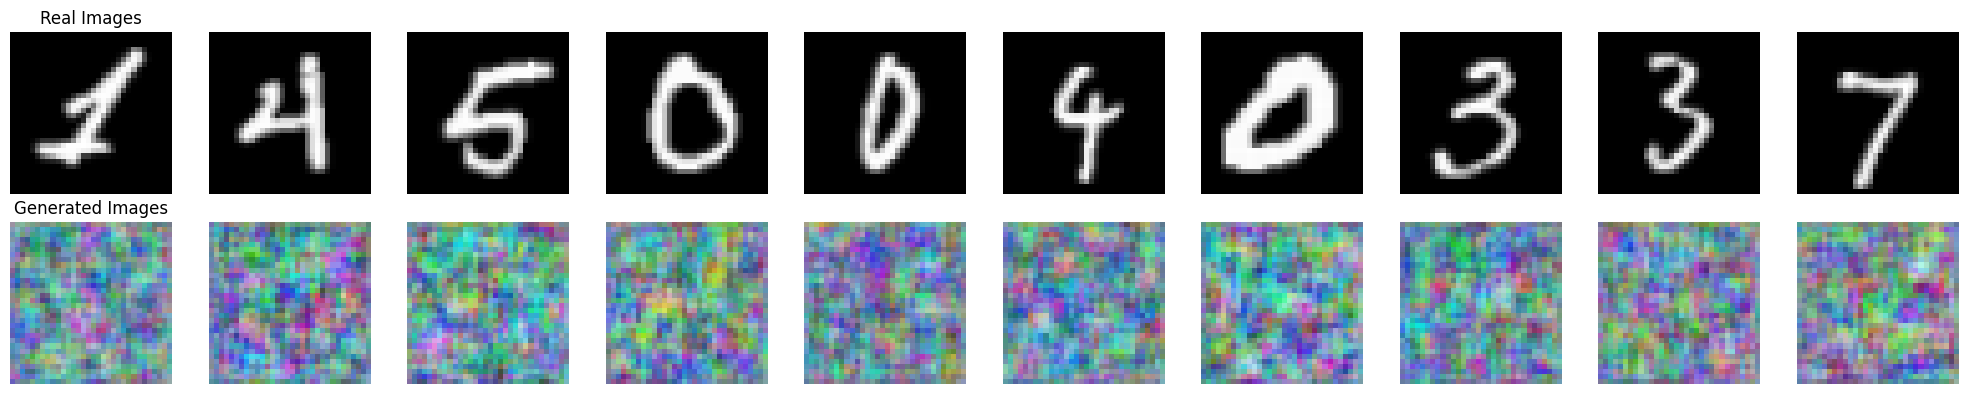

 FID : 382.4471310697394 , IS : 1.070629358291626
Training started...
[Epoch 1/30] Loss D: -0.0559, Loss G: 0.0191 , FID score : 129.7570 , IS score : 2.1895
[Epoch 2/30] Loss D: -0.0717, Loss G: 0.0272 , FID score : 107.4997 , IS score : 2.1681
[Epoch 3/30] Loss D: -0.0734, Loss G: 0.0281 , FID score : 89.9306 , IS score : 2.1322
[Epoch 4/30] Loss D: -0.0729, Loss G: 0.0277 , FID score : 74.8002 , IS score : 2.1316
[Epoch 5/30] Loss D: -0.0711, Loss G: 0.0270 , FID score : 67.9897 , IS score : 2.1670
[Epoch 6/30] Loss D: -0.0691, Loss G: 0.0262 , FID score : 64.8856 , IS score : 2.1626
[Epoch 7/30] Loss D: -0.0672, Loss G: 0.0253 , FID score : 60.8574 , IS score : 2.1778
[Epoch 8/30] Loss D: -0.0652, Loss G: 0.0245 , FID score : 54.3999 , IS score : 2.2097
[Epoch 9/30] Loss D: -0.0635, Loss G: 0.0236 , FID score : 49.3077 , IS score : 2.2275
[Epoch 10/30] Loss D: -0.0618, Loss G: 0.0227 , FID score : 46.9013 , IS score : 2.2171


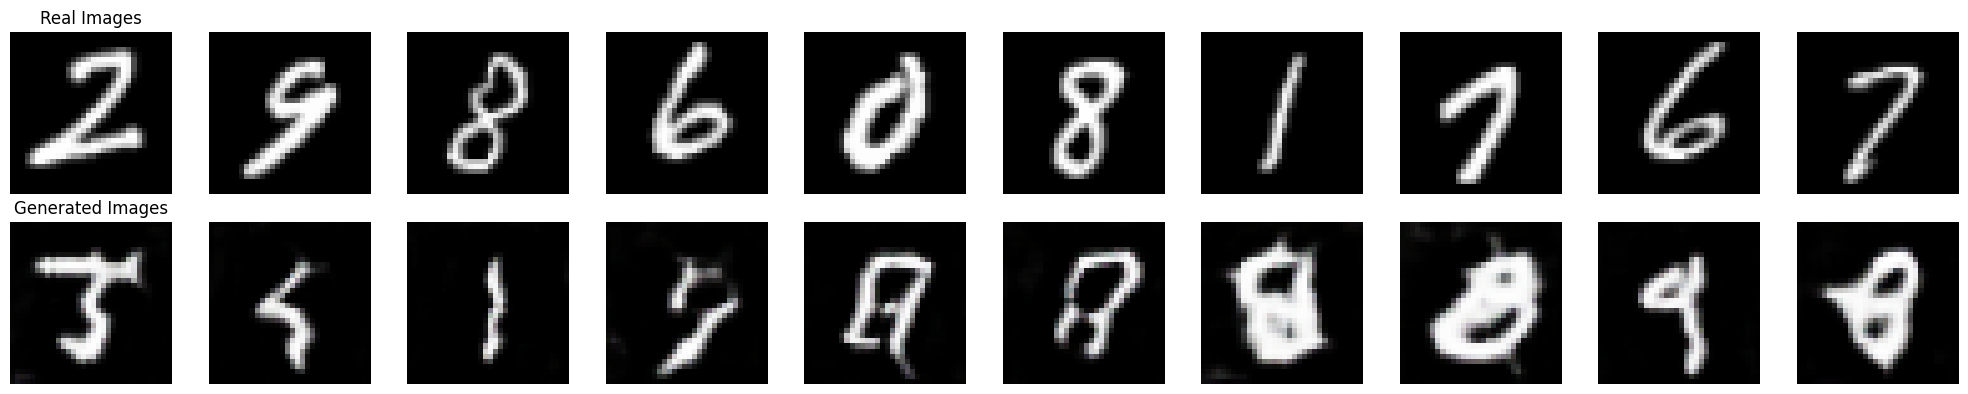

[Epoch 11/30] Loss D: -0.0603, Loss G: 0.0218 , FID score : 44.3522 , IS score : 2.2367
[Epoch 12/30] Loss D: -0.0588, Loss G: 0.0210 , FID score : 42.6156 , IS score : 2.2395
[Epoch 13/30] Loss D: -0.0574, Loss G: 0.0202 , FID score : 39.0587 , IS score : 2.2764
[Epoch 14/30] Loss D: -0.0562, Loss G: 0.0197 , FID score : 40.4237 , IS score : 2.2663
[Epoch 15/30] Loss D: -0.0550, Loss G: 0.0190 , FID score : 34.6492 , IS score : 2.3127
[Epoch 16/30] Loss D: -0.0541, Loss G: 0.0189 , FID score : 38.0196 , IS score : 2.2890
[Epoch 17/30] Loss D: -0.0532, Loss G: 0.0184 , FID score : 36.2113 , IS score : 2.3025
[Epoch 18/30] Loss D: -0.0524, Loss G: 0.0179 , FID score : 37.3871 , IS score : 2.3194
[Epoch 19/30] Loss D: -0.0517, Loss G: 0.0174 , FID score : 32.6215 , IS score : 2.3281
[Epoch 20/30] Loss D: -0.0511, Loss G: 0.0171 , FID score : 30.8802 , IS score : 2.2945


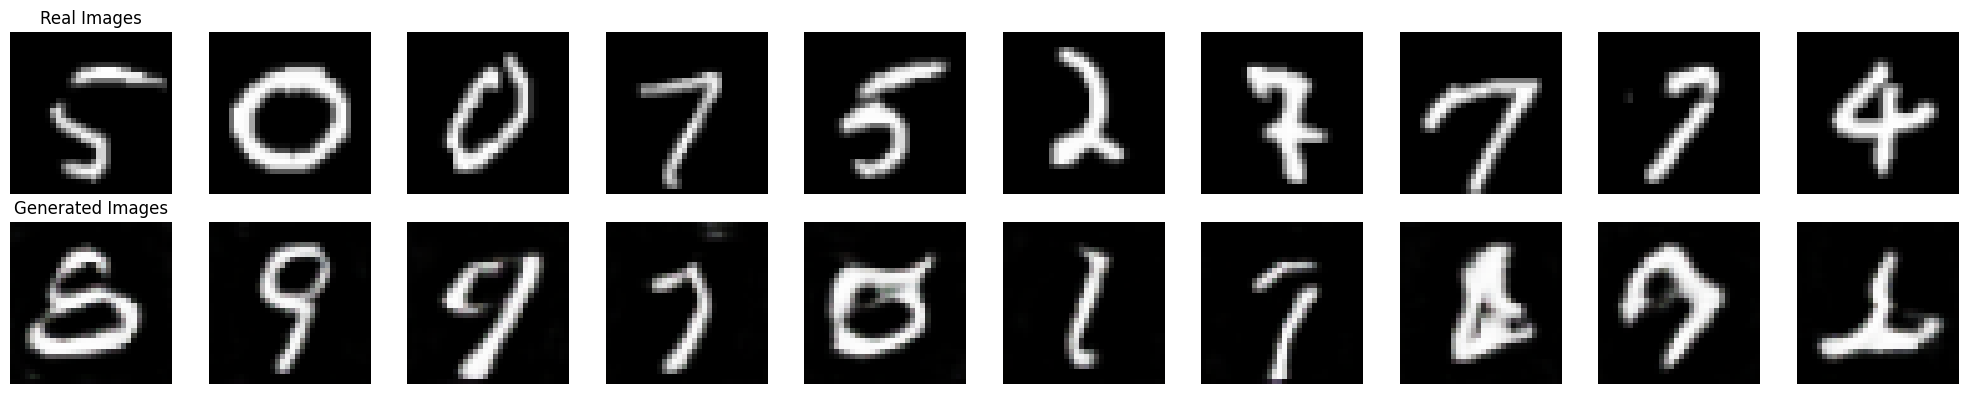

[Epoch 21/30] Loss D: -0.0505, Loss G: 0.0167 , FID score : 29.7624 , IS score : 2.2940
[Epoch 22/30] Loss D: -0.0499, Loss G: 0.0165 , FID score : 30.0956 , IS score : 2.3301
[Epoch 23/30] Loss D: -0.0495, Loss G: 0.0162 , FID score : 28.1074 , IS score : 2.3294
[Epoch 24/30] Loss D: -0.0491, Loss G: 0.0160 , FID score : 29.0192 , IS score : 2.3220
[Epoch 25/30] Loss D: -0.0487, Loss G: 0.0160 , FID score : 27.7262 , IS score : 2.3386
[Epoch 26/30] Loss D: -0.0484, Loss G: 0.0156 , FID score : 26.7080 , IS score : 2.3479
[Epoch 27/30] Loss D: -0.0482, Loss G: 0.0154 , FID score : 27.8830 , IS score : 2.3466
[Epoch 28/30] Loss D: -0.0479, Loss G: 0.0153 , FID score : 25.6116 , IS score : 2.3432
[Epoch 29/30] Loss D: -0.0476, Loss G: 0.0151 , FID score : 26.4614 , IS score : 2.3295
[Epoch 30/30] Loss D: -0.0474, Loss G: 0.0150 , FID score : 25.5385 , IS score : 2.3099


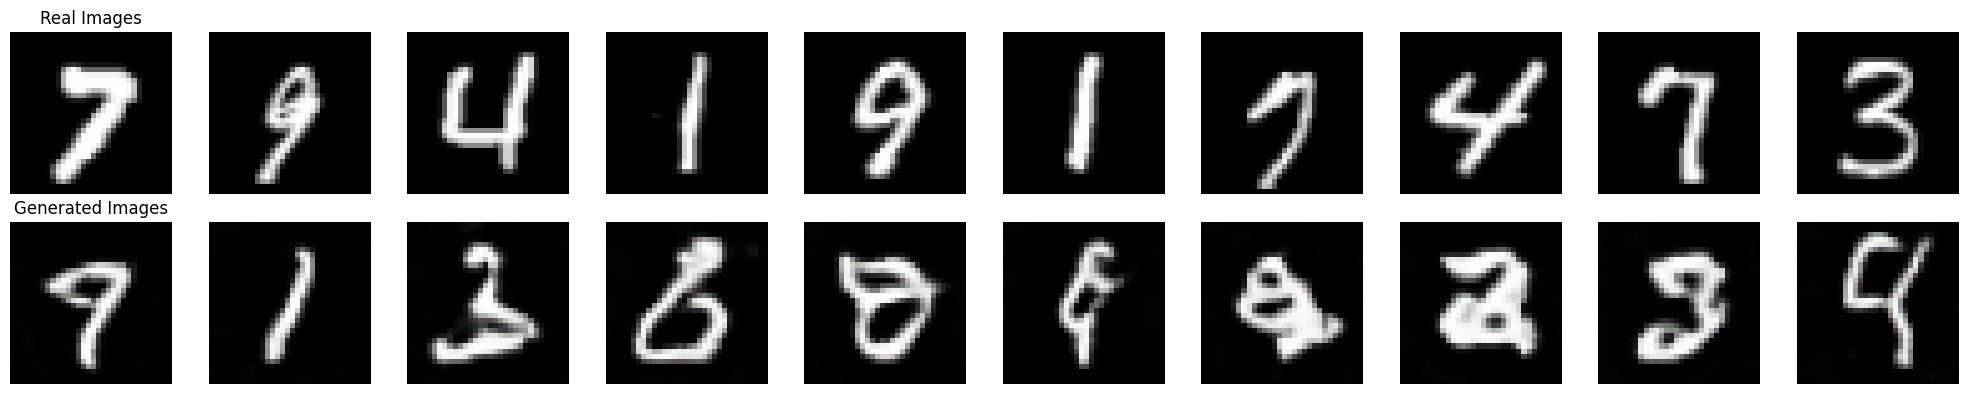

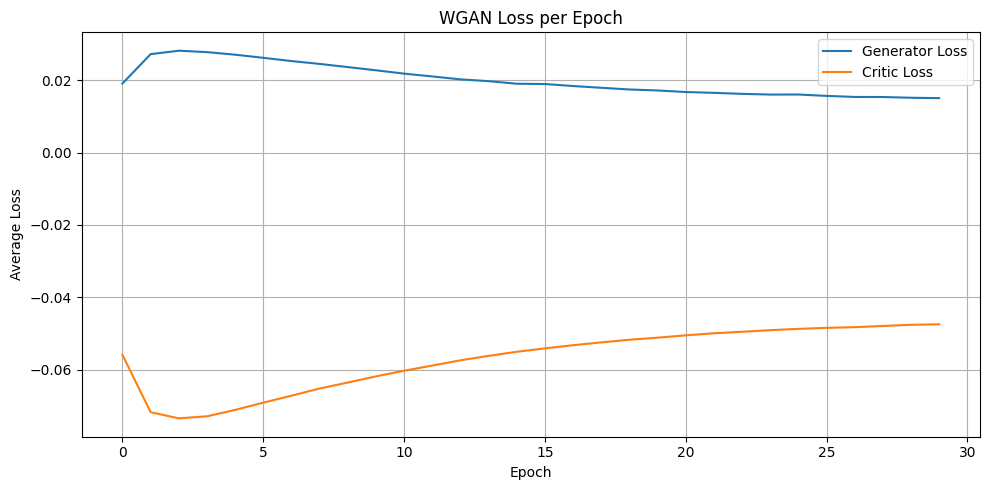

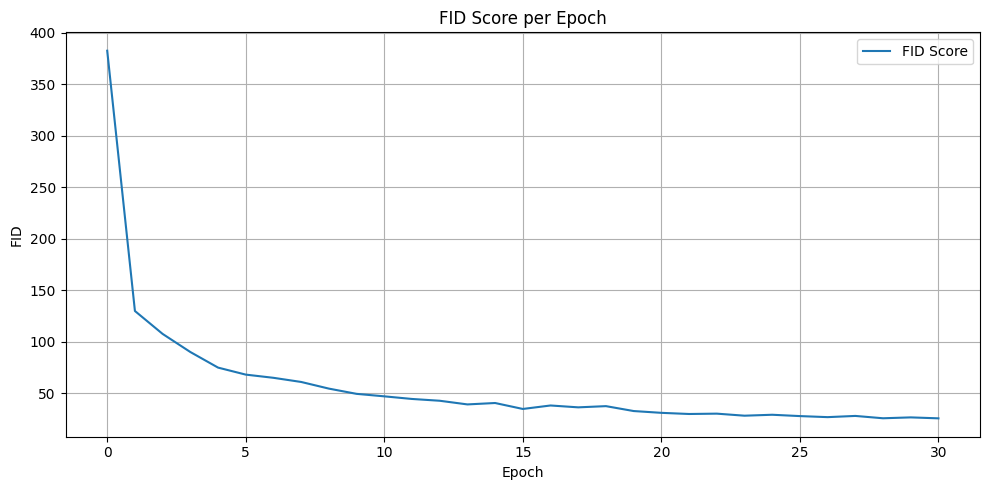

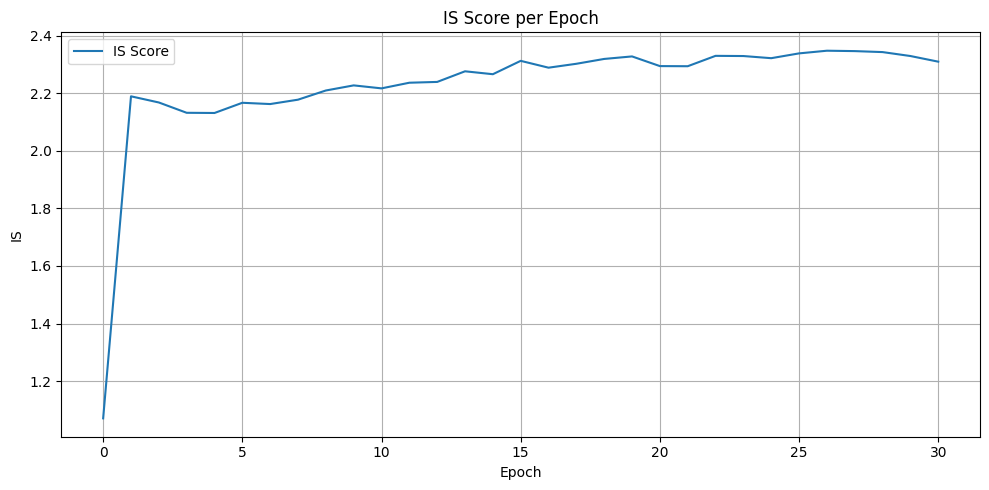

In [19]:
generator_1 = Generator(latent_dim).to(device)
critic_1 = Critic().to(device)
optimizer_g1 = optim.RMSprop(generator_1.parameters(), lr=lr)
optimizer_c1 = optim.RMSprop(critic_1.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_1(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_1, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
train_WGAN(generator_1, critic_1, optimizer_g1, optimizer_c1, dataloader, device, latent_dim, n_critic , c , n_epochs , val1 , val2)

In [ ]:
def train_vanillaGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_epochs , fid_0 , is_0):
    bce = torch.nn.BCELoss()
    Sigmoid = torch.nn.Sigmoid()
    os.makedirs("images_VanillaGAN", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):

            real_imgs = imgs.to(device)
            b_size = imgs.size(0)
            batches += 1

            optimizer_c.zero_grad()

            # Real images should get high probability (close to 1)
            real_output = Sigmoid(critic(real_imgs))
            real_loss = -torch.mean(torch.log(real_output + 1e-8))  # -log(D(x))

            # Fake images should get low probability (close to 0)
            z = torch.randn(b_size, latent_dim).to(device)
            fake_imgs = generator(z).detach()
            fake_output = Sigmoid(critic(fake_imgs))
            fake_loss = -torch.mean(torch.log(1 - fake_output + 1e-8))  # -log(1-D(G(z)))

            # Total discriminator loss (we minimize this, which maximizes the original objective)
            loss_c = real_loss + fake_loss
            c_loss_epoch += loss_c.item()
            loss_c.backward()
            optimizer_c.step()

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_output = Sigmoid(critic(gen_imgs))

            # Non-saturating loss: minimize -log(D(G(z)))
            loss_g = -torch.mean(torch.log(gen_output + 1e-8))
            g_loss_epoch += loss_g.item()
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        c_losses.append(avg_c_loss)
        g_losses.append(avg_g_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , Inception score : {is_score:.4f}")
        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_VanillaGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("vanilla-GAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='Inception Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def gradient_penalty(critic, real_samples, fake_samples, device):
    batch_size = real_samples.size(0)
    
    # Random interpolation coefficients (no grad needed)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    
    # Interpolate samples
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Forward pass
    d_interpolated = critic(interpolated)
    
    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Calculate penalty (L2 norm - 1)^2
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)  # More stable than manual sqrt
    penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return penalty

In [ ]:
def train_WGAN_GP(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , l , n_epochs , fid_0 , is_0 ):
    os.makedirs("images_WGAN-GP", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    is_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training
    is_scores.append(is_0)

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)
                
                gp = gradient_penalty(critic , real_imgs, fake_imgs, device)
                loss_c = torch.mean(fake_validity) - torch.mean(real_validity) + l * gp
                c_loss_n += loss_c.item()
                loss_c.backward()
                optimizer_c.step()
                
            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score , is_score , _ = evaluate_metrics(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID and IS in each epoch
        fid_scores.append(fid_score)
        is_scores.append(is_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f} , IS score : {is_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 10 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN-GP/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN_GP Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(is_scores, label='Inception Score')
    plt.xlabel("Epoch")
    plt.ylabel("IS")
    plt.title("IS Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Before Training...


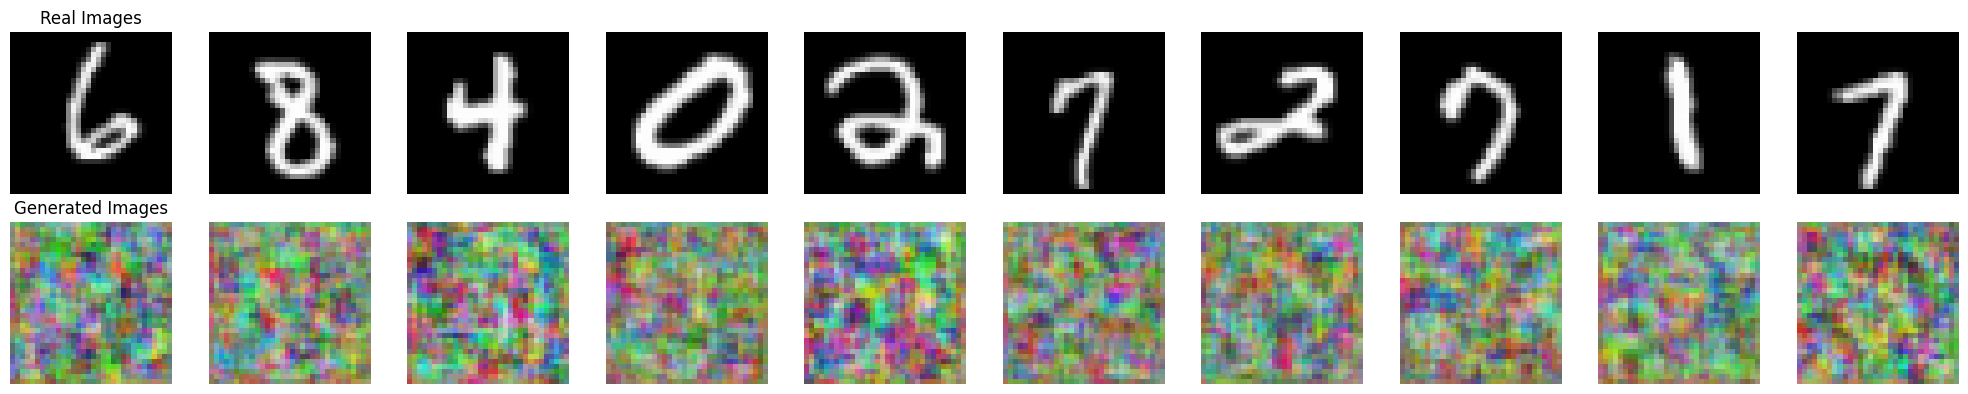

 FID : 359.9077803313444 , IS : 1.0838749408721924
Training started...


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 1/30] Loss D: -7.9323, Loss G: 7.4445 , FID score : 108.9392 , IS score : 2.3440
[Epoch 2/30] Loss D: -6.5922, Loss G: 14.3172 , FID score : 74.1311 , IS score : 2.3257
[Epoch 3/30] Loss D: -6.2339, Loss G: 20.8015 , FID score : 52.4667 , IS score : 2.3138
[Epoch 4/30] Loss D: -6.3749, Loss G: 23.4519 , FID score : 46.6086 , IS score : 2.3601
[Epoch 5/30] Loss D: -6.3588, Loss G: 23.6968 , FID score : 42.6322 , IS score : 2.3357
[Epoch 6/30] Loss D: -6.2143, Loss G: 23.5171 , FID score : 39.9814 , IS score : 2.2149
[Epoch 7/30] Loss D: -6.0635, Loss G: 22.4407 , FID score : 34.5545 , IS score : 2.2303
[Epoch 8/30] Loss D: -5.8789, Loss G: 21.2345 , FID score : 33.3707 , IS score : 2.2871
[Epoch 9/30] Loss D: -5.6844, Loss G: 19.9959 , FID score : 29.6262 , IS score : 2.3155
[Epoch 10/30] Loss D: -5.5145, Loss G: 18.7143 , FID score : 29.7818 , IS score : 2.3203


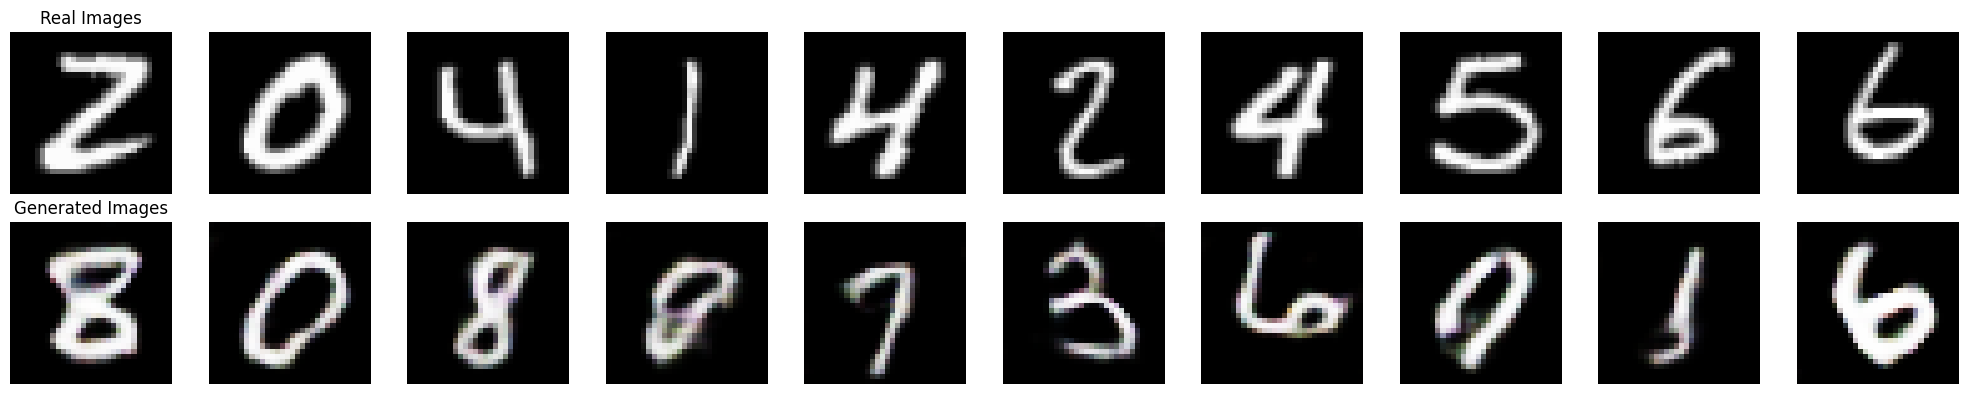

[Epoch 11/30] Loss D: -5.3173, Loss G: 17.5495 , FID score : 28.1429 , IS score : 2.3108
[Epoch 12/30] Loss D: -5.1648, Loss G: 16.2183 , FID score : 28.8906 , IS score : 2.3759
[Epoch 13/30] Loss D: -5.0140, Loss G: 14.8866 , FID score : 27.8587 , IS score : 2.2093
[Epoch 14/30] Loss D: -4.8702, Loss G: 13.6709 , FID score : 22.9578 , IS score : 2.3195
[Epoch 15/30] Loss D: -4.7581, Loss G: 12.2619 , FID score : 22.4928 , IS score : 2.3307
[Epoch 16/30] Loss D: -4.6714, Loss G: 10.8365 , FID score : 22.2501 , IS score : 2.3156
[Epoch 17/30] Loss D: -4.5793, Loss G: 9.6863 , FID score : 23.3395 , IS score : 2.2991
[Epoch 18/30] Loss D: -4.4741, Loss G: 8.7720 , FID score : 21.5619 , IS score : 2.2938
[Epoch 19/30] Loss D: -4.3771, Loss G: 8.0867 , FID score : 23.2130 , IS score : 2.1646
[Epoch 20/30] Loss D: -4.3113, Loss G: 7.1390 , FID score : 21.8637 , IS score : 2.3153


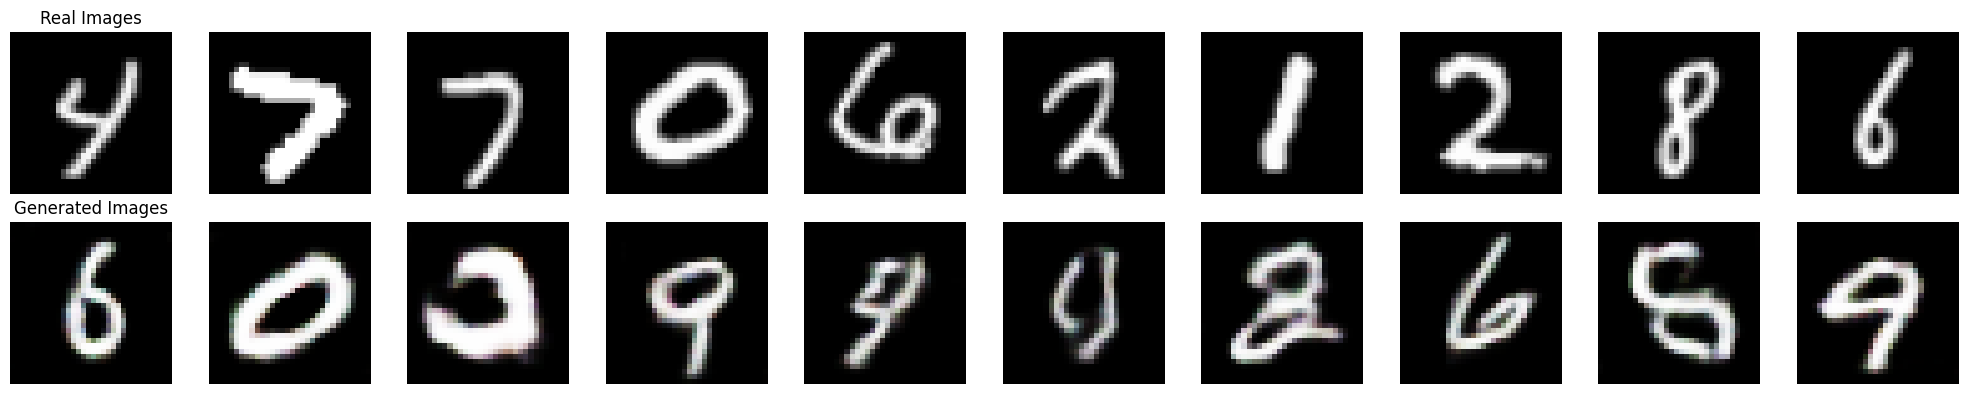

[Epoch 21/30] Loss D: -4.2564, Loss G: 6.3805 , FID score : 18.7576 , IS score : 2.3617
[Epoch 22/30] Loss D: -4.1583, Loss G: 5.8291 , FID score : 19.3699 , IS score : 2.2594
[Epoch 23/30] Loss D: -4.1038, Loss G: 5.5100 , FID score : 21.0148 , IS score : 2.3158
[Epoch 24/30] Loss D: -4.0291, Loss G: 4.9681 , FID score : 18.6636 , IS score : 2.3183
[Epoch 25/30] Loss D: -3.9728, Loss G: 4.6955 , FID score : 18.4270 , IS score : 2.2981
[Epoch 26/30] Loss D: -3.9141, Loss G: 4.2475 , FID score : 15.9764 , IS score : 2.3777
[Epoch 27/30] Loss D: -3.8411, Loss G: 3.5080 , FID score : 17.2269 , IS score : 2.3488
[Epoch 28/30] Loss D: -3.8006, Loss G: 3.3960 , FID score : 16.5550 , IS score : 2.3513
[Epoch 29/30] Loss D: -3.7510, Loss G: 3.2157 , FID score : 16.9264 , IS score : 2.3154
[Epoch 30/30] Loss D: -3.7053, Loss G: 2.8371 , FID score : 16.7255 , IS score : 2.3146


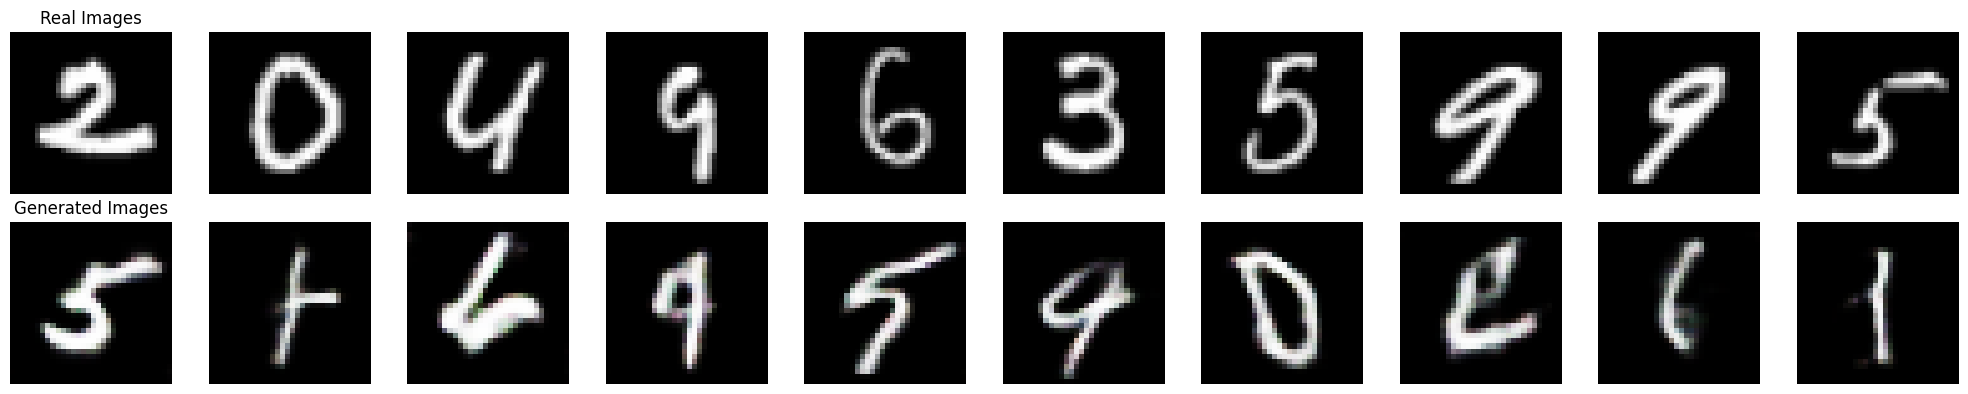

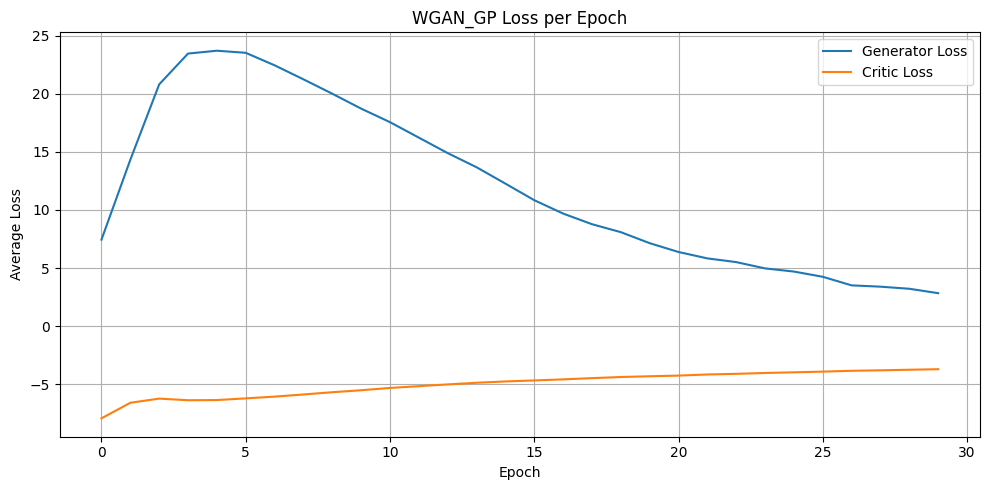

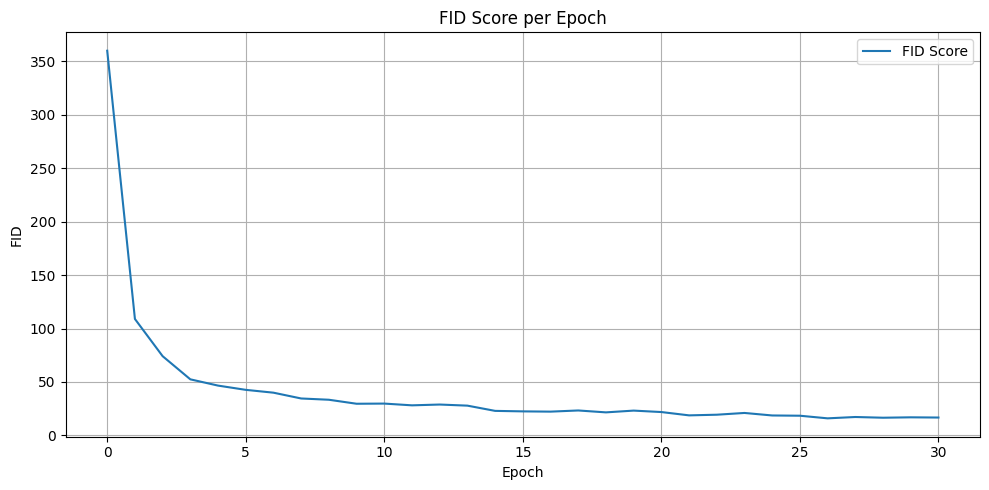

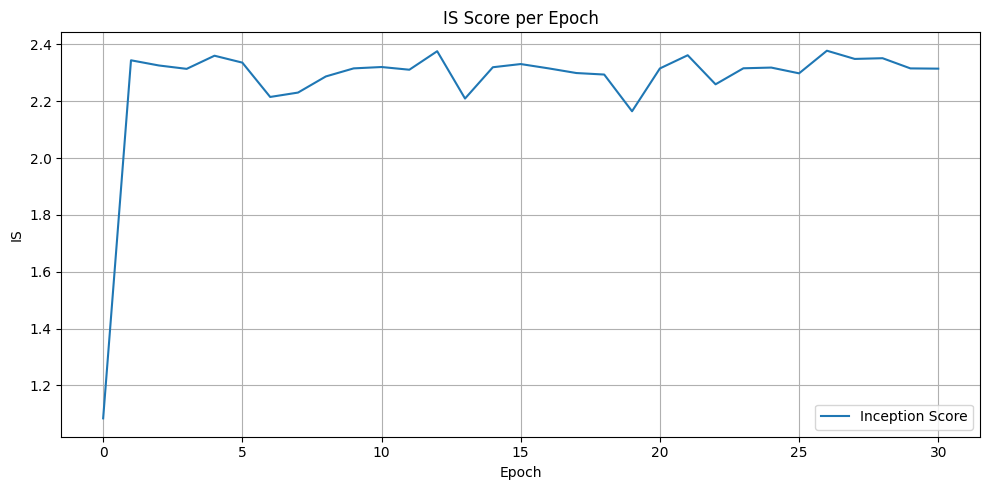

In [ ]:
generator_2 = Generator(latent_dim).to(device)
critic_2 = Critic().to(device)
optimizer_g2 = optim.Adam(generator_2.parameters(), lr=1e-4,betas=(0.0, 0.9))
optimizer_c2 = optim.Adam(critic_2.parameters(), lr=1e-4 ,betas=(0.0, 0.9))

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_2(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_2, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
train_WGAN_GP(generator_2, critic_2, optimizer_g2, optimizer_c2, dataloader, device, latent_dim, n_critic , l , n_epochs , fid_0 = val1 , is_0 = val2)

Before Training...


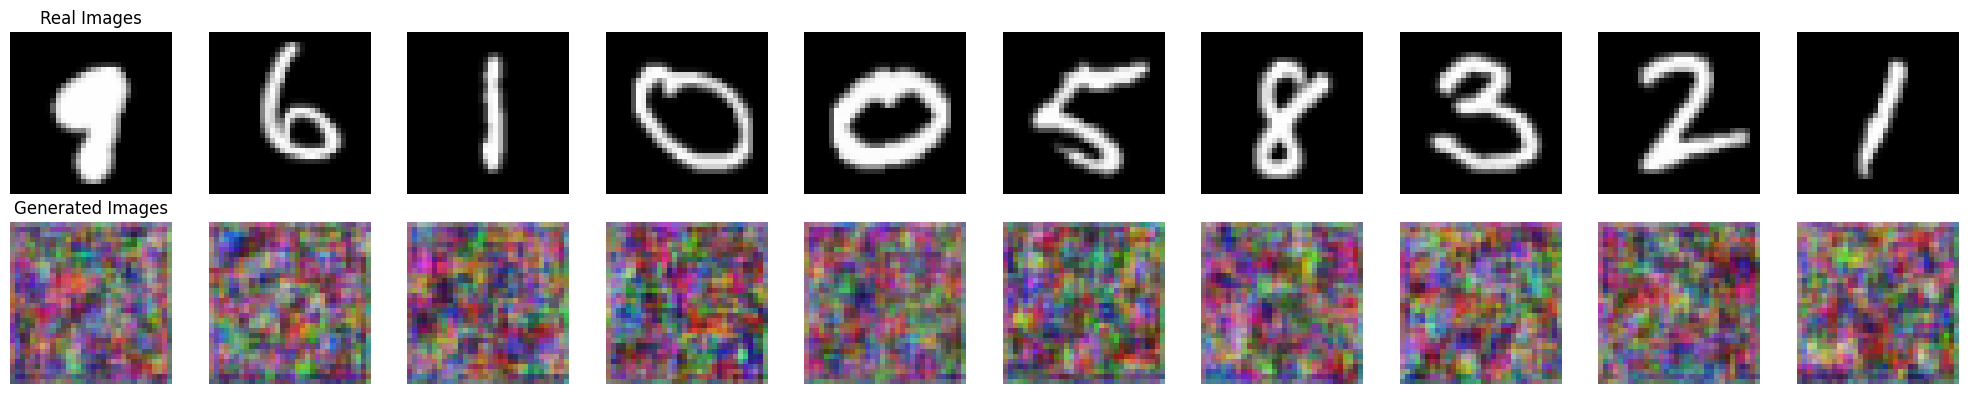

 FID : 369.8888190375403 , IS : 1.089133858680725
Training started...
[Epoch 1/30] Loss D: 0.6569, Loss G: 1.9989 , FID score : 152.9441 , Inception score : 2.0954
[Epoch 2/30] Loss D: 0.8159, Loss G: 1.5722 , FID score : 100.4714 , Inception score : 2.3165
[Epoch 3/30] Loss D: 0.8111, Loss G: 1.5902 , FID score : 81.0513 , Inception score : 2.3030
[Epoch 4/30] Loss D: 0.8130, Loss G: 1.6254 , FID score : 61.2478 , Inception score : 2.2584
[Epoch 5/30] Loss D: 0.8284, Loss G: 1.6226 , FID score : 53.8607 , Inception score : 2.2416
[Epoch 6/30] Loss D: 0.8369, Loss G: 1.6180 , FID score : 48.6008 , Inception score : 2.2349
[Epoch 7/30] Loss D: 0.8250, Loss G: 1.6522 , FID score : 43.8852 , Inception score : 2.2927
[Epoch 8/30] Loss D: 0.8195, Loss G: 1.6650 , FID score : 40.4471 , Inception score : 2.1997
[Epoch 9/30] Loss D: 0.8336, Loss G: 1.6662 , FID score : 39.4018 , Inception score : 2.3091
[Epoch 10/30] Loss D: 0.8290, Loss G: 1.6696 , FID score : 34.0768 , Inception score : 2.27

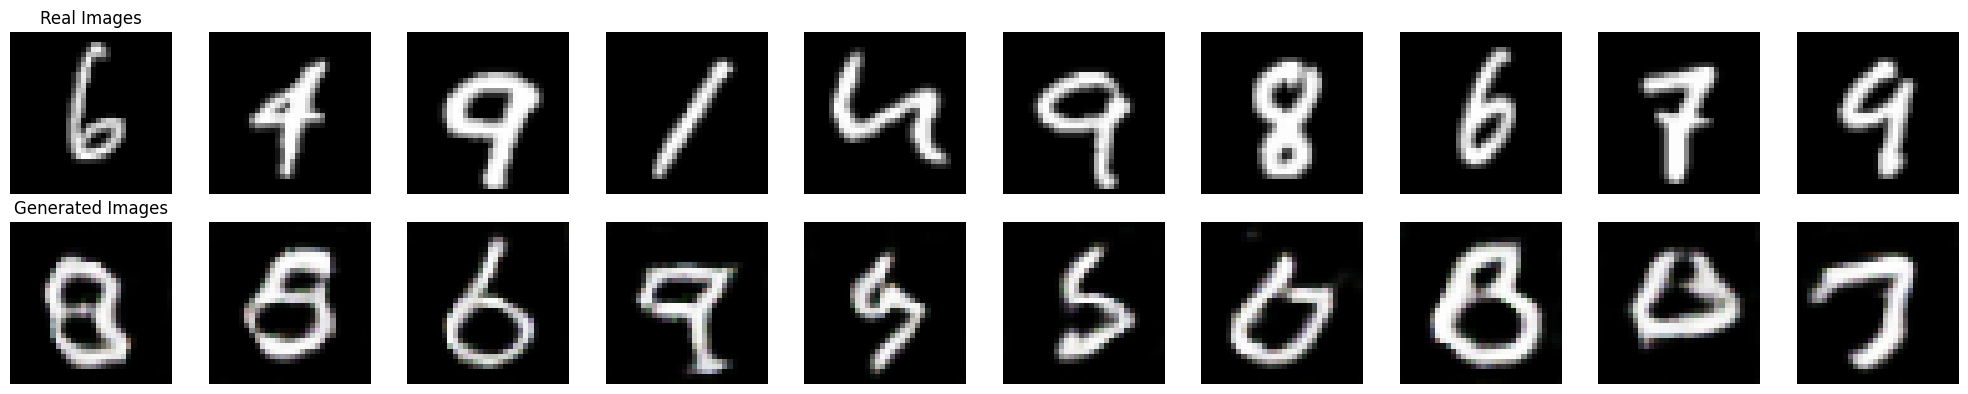

[Epoch 11/30] Loss D: 0.8356, Loss G: 1.6510 , FID score : 32.1048 , Inception score : 2.1915
[Epoch 12/30] Loss D: 0.8420, Loss G: 1.6528 , FID score : 31.9915 , Inception score : 2.2526
[Epoch 13/30] Loss D: 0.8491, Loss G: 1.6342 , FID score : 29.5157 , Inception score : 2.2501
[Epoch 14/30] Loss D: 0.8539, Loss G: 1.6266 , FID score : 27.5532 , Inception score : 2.2100
[Epoch 15/30] Loss D: 0.8564, Loss G: 1.6226 , FID score : 26.6866 , Inception score : 2.1994
[Epoch 16/30] Loss D: 0.8557, Loss G: 1.6154 , FID score : 26.8125 , Inception score : 2.2296
[Epoch 17/30] Loss D: 0.8603, Loss G: 1.6219 , FID score : 25.9256 , Inception score : 2.1907
[Epoch 18/30] Loss D: 0.8504, Loss G: 1.6266 , FID score : 25.3082 , Inception score : 2.2583
[Epoch 19/30] Loss D: 0.8509, Loss G: 1.6310 , FID score : 25.3821 , Inception score : 2.2623
[Epoch 20/30] Loss D: 0.8405, Loss G: 1.6552 , FID score : 23.7731 , Inception score : 2.2231


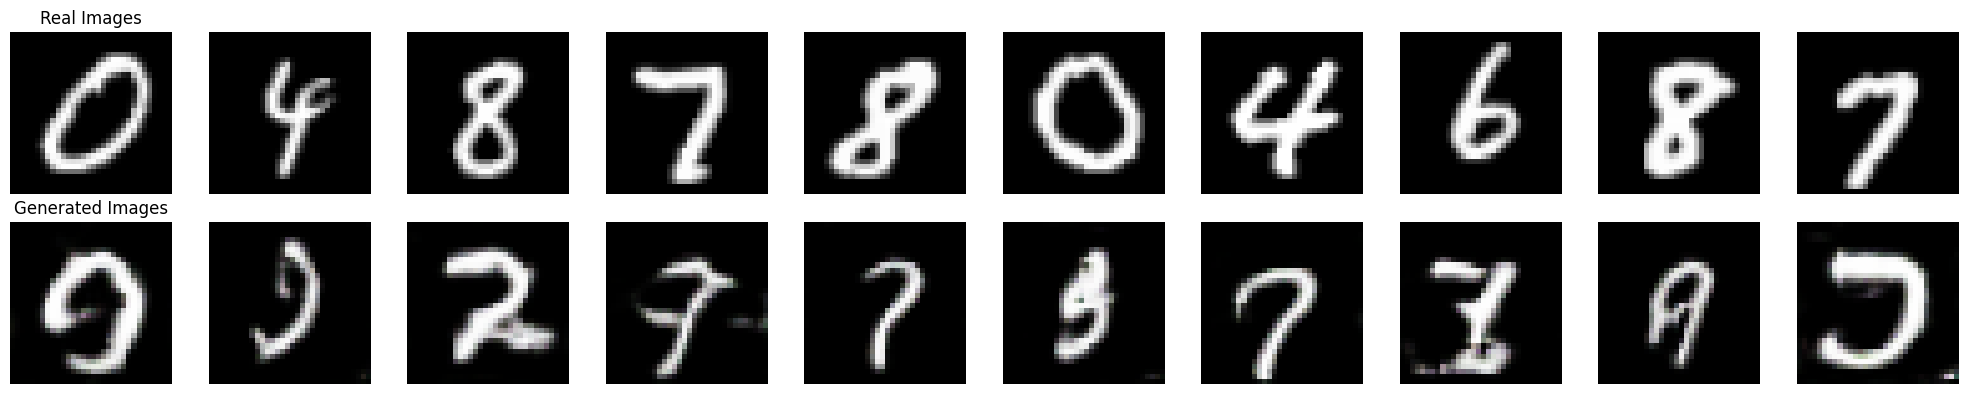

[Epoch 21/30] Loss D: 0.8271, Loss G: 1.6828 , FID score : 23.3795 , Inception score : 2.2477
[Epoch 22/30] Loss D: 0.8176, Loss G: 1.7108 , FID score : 23.1397 , Inception score : 2.2561
[Epoch 23/30] Loss D: 0.8071, Loss G: 1.7458 , FID score : 22.8836 , Inception score : 2.2542
[Epoch 24/30] Loss D: 0.7876, Loss G: 1.7713 , FID score : 22.5733 , Inception score : 2.2554
[Epoch 25/30] Loss D: 0.7853, Loss G: 1.8044 , FID score : 23.5841 , Inception score : 2.2646
[Epoch 26/30] Loss D: 0.7681, Loss G: 1.8558 , FID score : 23.4319 , Inception score : 2.2444
[Epoch 27/30] Loss D: 0.7564, Loss G: 1.8957 , FID score : 25.0502 , Inception score : 2.3145
[Epoch 28/30] Loss D: 0.7442, Loss G: 1.9280 , FID score : 22.6936 , Inception score : 2.2986
[Epoch 29/30] Loss D: 0.7226, Loss G: 1.9697 , FID score : 22.4904 , Inception score : 2.2908
[Epoch 30/30] Loss D: 0.7121, Loss G: 2.0286 , FID score : 22.1200 , Inception score : 2.2693


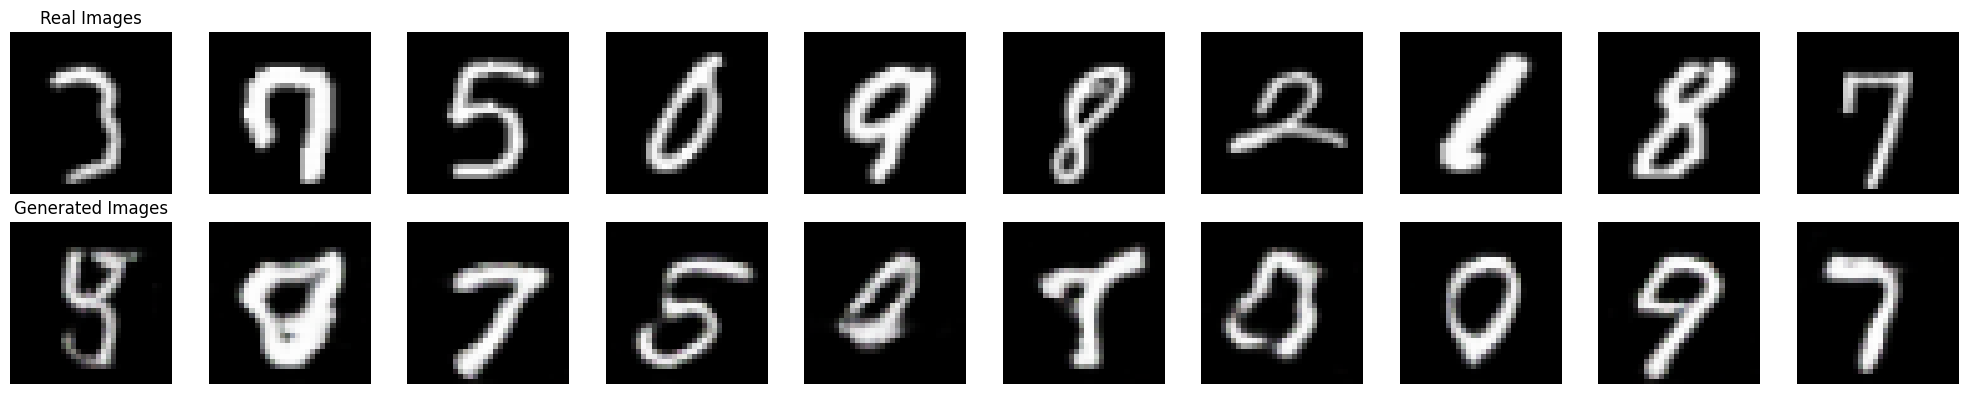

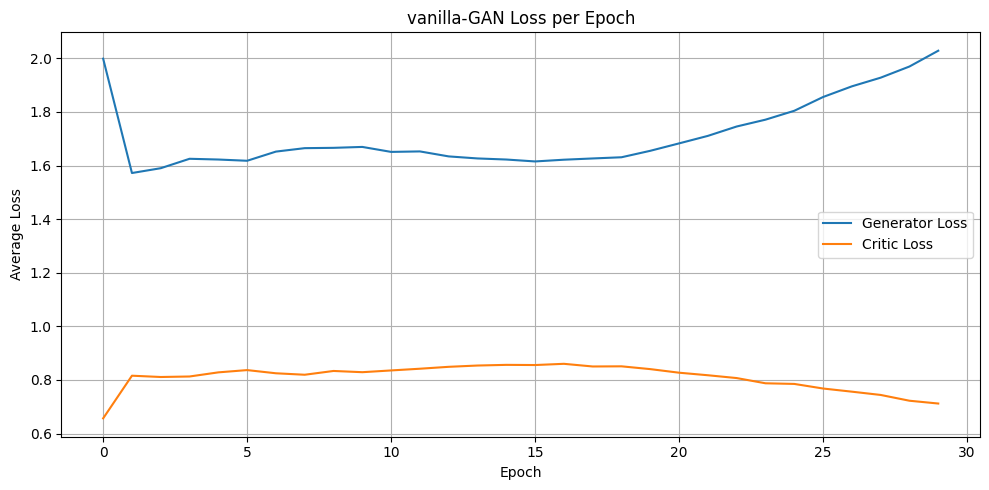

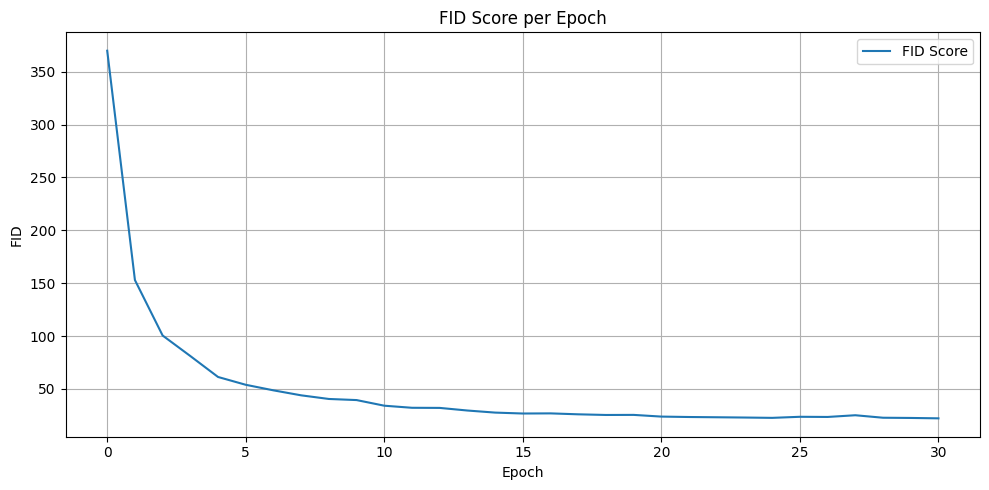

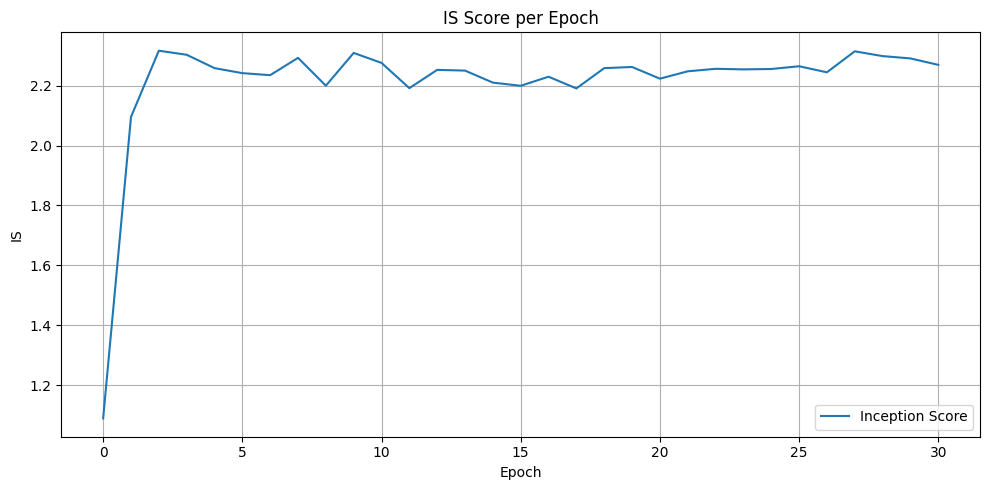

In [ ]:
generator_3 = Generator(latent_dim).to(device)
critic_3 = Critic().to(device)
optimizer_g3 = optim.Adam(generator_3.parameters(), lr=lr,betas=(0.5, 0.999))
optimizer_c3 = optim.Adam(critic_3.parameters(), lr=lr ,betas=(0.5, 0.999))

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_3(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val1 , val2 , _ = evaluate_metrics(generator_3, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val1} , IS : {val2}")
print("Training started...")

# Start training
train_vanillaGAN(generator_3, critic_3, optimizer_g3, optimizer_c3, dataloader, device, latent_dim, n_epochs , val1 , val2)